In [3]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
from tqdm import tqdm

nltk.download('punkt')
nltk.download('punkt_tab')

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)
import torch

# Automatically use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Load dataset and image embeddings
file_path = '/content/drive/MyDrive/undersampled_movie_metadata.csv'
df = pd.read_csv(file_path)
image_embeddings = torch.load('/content/drive/MyDrive/poster_embeddings.pt')
print(f"Loaded tensor with shape: {image_embeddings.shape}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Mounted at /content/drive
Using device: cpu


<ipython-input-3-73736930854c>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_embeddings = torch.load('/content/drive/MyDrive/poster_embeddings.pt')


Loaded tensor with shape: torch.Size([20530, 1280])


In [4]:
# Combine title and overview for text data
df['text'] = df['title'].fillna('') + ' ' + df['overview'].fillna('')

# Define genre columns
genre_columns = ['Drama', 'Comedy', 'Documentary', 'Romance', 'Action', 'Thriller',
                 'Horror', 'Crime', 'Music', 'Animation', 'TV Movie', 'Family']
for col in genre_columns:
    df[col] = df[col].astype(int)

# Split dataset
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Build vocabulary
def build_vocab(texts, min_freq=2):
    all_tokens = [word_tokenize(text.lower()) for text in texts]
    counter = Counter(token for tokens in all_tokens for token in tokens)
    vocab = {word: idx + 2 for idx, (word, count) in enumerate(counter.items()) if count >= min_freq}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1
    return vocab

texts = train_df['text'].tolist()
vocab = build_vocab(texts)
print(f"Vocabulary size: {len(vocab)}")

def text_pipeline(text, vocab, max_len=200):
    tokens = word_tokenize(text.lower())
    token_ids = [vocab.get(token, vocab['<unk>']) for token in tokens][:max_len]
    padded = token_ids + [vocab['<pad>']] * (max_len - len(token_ids))
    padded = [min(max(idx, 0), len(vocab) - 1) for idx in padded]
    return torch.tensor(padded, dtype=torch.long)

# Save vocab
torch.save(vocab, '/content/drive/MyDrive/vocab.pt')

# Split image embeddings
train_embeddings = image_embeddings[:len(train_df)]
val_embeddings = image_embeddings[len(train_df):len(train_df) + len(val_df)]
test_embeddings = image_embeddings[len(train_df) + len(val_df):]

Train: 14371, Val: 3079, Test: 3080
Vocabulary size: 23954


In [7]:
class TextModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(TextModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.3)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        features = h_n[-1]
        x = self.fc(features)
        return x

    def get_features(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        return h_n[-1]

# Hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_classes = len(genre_columns)

# Initialize text model
text_model = TextModel(vocab_size, embedding_dim, hidden_dim, num_classes).to(device)
# Verify trainable parameters
for name, param in text_model.named_parameters():
    assert param.requires_grad, f"Parameter {name} does not require gradients!"

USING EMBEDDINGS GENERATED in IMAGE MODEL

In [9]:
class RESNET_18(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(RESNET_18, self).__init__()
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

    def get_features(self, x):
        return x

# Initialize image model
image_model = RESNET_18(1280, num_classes).to(device)
# Verify trainable parameters
for name, param in image_model.named_parameters():
    assert param.requires_grad, f"Parameter {name} does not require gradients!"

In [20]:
class FusionModel(nn.Module):
    def __init__(self, text_model, image_model, text_feature_size, image_feature_size, num_classes):
        super(FusionModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        self.fusion_layer = nn.Linear(text_feature_size + image_feature_size, 512)
        self.classifier = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        for param in self.text_model.parameters():
            param.requires_grad = False
        for param in self.image_model.parameters():
            param.requires_grad = False

    def forward(self, text_input, image_input):
        text_features = self.text_model.get_features(text_input)
        image_features = self.image_model.get_features(image_input)
        fused_features = torch.cat((text_features, image_features), dim=1)
        fused_features = self.fusion_layer(fused_features)
        fused_features = self.relu(fused_features)
        output = self.classifier(fused_features)
        return output

In [21]:
class TextImageDataset(Dataset):
    def __init__(self, df, embeddings, vocab, genre_columns):
        self.texts = df['text'].tolist()
        self.embeddings = embeddings
        self.labels = df[genre_columns].values
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = text_pipeline(self.texts[idx], self.vocab)
        if text.max() >= len(self.vocab) or text.min() < 0:
            raise ValueError(f"Invalid index detected: max={text.max()}, min={text.min()}")
        embedding = self.embeddings[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return text, embedding, label

# Create datasets
train_dataset = TextImageDataset(train_df, train_embeddings, vocab, genre_columns)
val_dataset = TextImageDataset(val_df, val_embeddings, vocab, genre_columns)
test_dataset = TextImageDataset(test_df, test_embeddings, vocab, genre_columns)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Training Text Model...


Epoch 1: 100%|██████████| 450/450 [00:16<00:00, 27.61it/s]


Epoch 1, Train Loss: 0.3789


Epoch 2: 100%|██████████| 450/450 [00:15<00:00, 28.36it/s]


Epoch 2, Train Loss: 0.3596


Epoch 3: 100%|██████████| 450/450 [00:15<00:00, 28.29it/s]


Epoch 3, Train Loss: 0.3370


Epoch 4: 100%|██████████| 450/450 [00:15<00:00, 28.51it/s]


Epoch 4, Train Loss: 0.3170


Epoch 5: 100%|██████████| 450/450 [00:17<00:00, 26.09it/s]


Epoch 5, Train Loss: 0.2995


Epoch 6: 100%|██████████| 450/450 [00:17<00:00, 25.92it/s]


Epoch 6, Train Loss: 0.2845


Epoch 7: 100%|██████████| 450/450 [00:16<00:00, 28.10it/s]


Epoch 7, Train Loss: 0.2704


Epoch 8: 100%|██████████| 450/450 [00:15<00:00, 28.16it/s]


Epoch 8, Train Loss: 0.2579


Epoch 9: 100%|██████████| 450/450 [00:16<00:00, 26.94it/s]


Epoch 9, Train Loss: 0.2452


Epoch 10: 100%|██████████| 450/450 [00:15<00:00, 28.28it/s]


Epoch 10, Train Loss: 0.2329
Text-Only - F1: 0.4520, Accuracy: 0.1581
Training Image Model...


Epoch 1: 100%|██████████| 450/450 [00:08<00:00, 52.45it/s]


Epoch 1, Train Loss: 0.4699


Epoch 2: 100%|██████████| 450/450 [00:07<00:00, 61.09it/s]


Epoch 2, Train Loss: 0.4500


Epoch 3: 100%|██████████| 450/450 [00:09<00:00, 49.28it/s]


Epoch 3, Train Loss: 0.4496


Epoch 4: 100%|██████████| 450/450 [00:07<00:00, 56.37it/s]


Epoch 4, Train Loss: 0.4497


Epoch 5: 100%|██████████| 450/450 [00:07<00:00, 56.53it/s]


Epoch 5, Train Loss: 0.4494


Epoch 6: 100%|██████████| 450/450 [00:08<00:00, 52.12it/s]


Epoch 6, Train Loss: 0.4497


Epoch 7: 100%|██████████| 450/450 [00:07<00:00, 58.20it/s]


Epoch 7, Train Loss: 0.4495


Epoch 8: 100%|██████████| 450/450 [00:08<00:00, 52.23it/s]


Epoch 8, Train Loss: 0.4494


Epoch 9: 100%|██████████| 450/450 [00:08<00:00, 51.75it/s]


Epoch 9, Train Loss: 0.4497


Epoch 10: 100%|██████████| 450/450 [00:08<00:00, 55.48it/s]


Epoch 10, Train Loss: 0.4495
Image-Only - F1: 0.0000, Accuracy: 0.0000
Training Fusion Model...


Epoch 1: 100%|██████████| 450/450 [00:14<00:00, 31.31it/s]


Epoch 1, Train Loss: 0.3390


Epoch 2: 100%|██████████| 450/450 [00:13<00:00, 34.01it/s]


Epoch 2, Train Loss: 0.2446


Epoch 3: 100%|██████████| 450/450 [00:12<00:00, 35.57it/s]


Epoch 3, Train Loss: 0.2317


Epoch 4: 100%|██████████| 450/450 [00:12<00:00, 35.78it/s]


Epoch 4, Train Loss: 0.2262


Epoch 5: 100%|██████████| 450/450 [00:12<00:00, 35.84it/s]


Epoch 5, Train Loss: 0.2232


Epoch 6: 100%|██████████| 450/450 [00:12<00:00, 35.86it/s]


Epoch 6, Train Loss: 0.2213


Epoch 7: 100%|██████████| 450/450 [00:12<00:00, 34.99it/s]


Epoch 7, Train Loss: 0.2200


Epoch 8: 100%|██████████| 450/450 [00:12<00:00, 35.96it/s]


Epoch 8, Train Loss: 0.2186


Epoch 9: 100%|██████████| 450/450 [00:12<00:00, 35.81it/s]


Epoch 9, Train Loss: 0.2180


Epoch 10: 100%|██████████| 450/450 [00:12<00:00, 35.07it/s]


Epoch 10, Train Loss: 0.2177
Fusion Model - F1: 0.4609, Accuracy: 0.1679


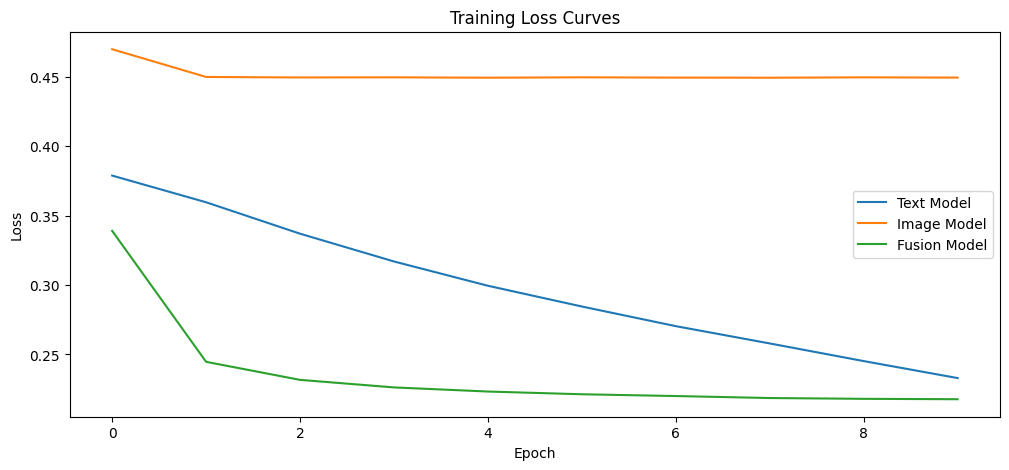

In [13]:
# Training function
def train_model(model, loader, criterion, optimizer, num_epochs, is_fusion=False):
    train_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}"):
            if is_fusion:
                texts, embeddings, labels = batch
                texts, embeddings, labels = texts.to(device), embeddings.to(device), labels.to(device)
                outputs = model(texts, embeddings)
            elif isinstance(model, TextModel):
                texts, _, labels = batch
                texts, labels = texts.to(device), labels.to(device)
                outputs = model(texts)
            elif isinstance(model, RESNET_18):
                _, embeddings, labels = batch
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings)
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")
    return train_losses

# Evaluation function
def evaluate_model(model, loader, is_fusion=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            if is_fusion:
                texts, embeddings, label = batch
                texts, embeddings, label = texts.to(device), embeddings.to(device), label.to(device)
                outputs = model(texts, embeddings)
            elif isinstance(model, TextModel):
                texts, _, label = batch
                texts, label = texts.to(device), label.to(device)
                outputs = model(texts)
            else:
                _, embeddings, label = batch
                embeddings, label = embeddings.to(device), label.to(device)
                outputs = model(embeddings)
            preds = (outputs > 0).float().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(label.cpu().numpy())
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    f1 = f1_score(all_labels, all_preds, average='micro')
    accuracy = accuracy_score(all_labels, all_preds)
    cm = multilabel_confusion_matrix(all_labels, all_preds)
    return f1, accuracy, cm

# Plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm.mean(axis=0), annot=True, fmt='.2f', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'/content/drive/MyDrive/Datasets/{title.replace(" ", "_")}.png')
    plt.close()

# Train and evaluate models
criterion = nn.BCEWithLogitsLoss()

print("Training Text Model...")
text_optimizer = optim.AdamW(text_model.parameters(), lr=0.001)
text_train_losses = train_model(text_model, train_loader, criterion, text_optimizer, 10)
text_f1, text_accuracy, text_cm = evaluate_model(text_model, test_loader)
print(f"Text-Only - F1: {text_f1:.4f}, Accuracy: {text_accuracy:.4f}")
plot_confusion_matrix(text_cm, 'Text-Only Confusion Matrix')

print("Training Image Model...")
image_optimizer = optim.AdamW(image_model.parameters(), lr=0.0001)
image_train_losses = train_model(image_model, train_loader, criterion, image_optimizer, 10)
image_f1, image_accuracy, image_cm = evaluate_model(image_model, test_loader)
print(f"Image-Only - F1: {image_f1:.4f}, Accuracy: {image_accuracy:.4f}")
plot_confusion_matrix(image_cm, 'Image-Only Confusion Matrix')

# Initialize fusion model after training text and image models
fusion_model = FusionModel(text_model, image_model, hidden_dim, 1280, num_classes).to(device)

print("Training Fusion Model...")
fusion_optimizer = optim.AdamW(fusion_model.parameters(), lr=0.0001)
fusion_train_losses = train_model(fusion_model, train_loader, criterion, fusion_optimizer, 10, is_fusion=True)
fusion_f1, fusion_accuracy, fusion_cm = evaluate_model(fusion_model, test_loader, is_fusion=True)
print(f"Fusion Model - F1: {fusion_f1:.4f}, Accuracy: {fusion_accuracy:.4f}")
plot_confusion_matrix(fusion_cm, 'Fusion Confusion Matrix')

# Plot training losses
plt.figure(figsize=(12, 5))
plt.plot(text_train_losses, label='Text Model')
plt.plot(image_train_losses, label='Image Model')
plt.plot(fusion_train_losses, label='Fusion Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.savefig('/content/drive/MyDrive/Datasets/training_losses.png')
plt.show()